## Segmentation

In [36]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
from torch.utils.data import DataLoader

In [45]:
class UNet(nn.Module):

  def __init__(self, in_ch, num_classes, transposed=True):
    super().__init__()

    self.dconv_down1 = self._double_conv(in_ch, 64)
    self.dconv_down2 = self._double_conv(64, 128)
    self.dconv_down3 = self._double_conv(128, 256)
    self.dconv_down4 = self._double_conv(256, 512)
    self.dconv_down5 = self._double_conv(512, 1024)

    self.maxpool = nn.MaxPool2d(2)

    self.upconv4 = self._up_conv(1024, 512, transposed=transposed)
    self.upconv3 = self._up_conv(512, 256, transposed=transposed)
    self.upconv2 = self._up_conv(256, 128, transposed=transposed)
    self.upconv1 = self._up_conv(128, 64, transposed=transposed)

    self.dconv_up4 = self._double_conv(1024, 512)
    self.dconv_up3 = self._double_conv(512, 256)
    self.dconv_up2 = self._double_conv(256, 128)
    self.dconv_up1 = self._double_conv(128, 64)

    self.conv_last = nn.Conv2d(64, num_classes, 1)


  def _double_conv(self, in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.ReLU(),
    )

  def _up_conv(self, in_ch, out_ch, transposed=True):
    if transposed:
      return nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    else:
      return nn.Sequential(
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
          nn.Conv2d(in_ch, out_ch, 1))


  def forward(self, X):
    conv1 = self.dconv_down1(X)
    X = self.maxpool(conv1)

    conv2 = self.dconv_down2(X)
    X = self.maxpool(conv2)

    conv3 = self.dconv_down3(X)
    X = self.maxpool(conv3)

    conv4 = self.dconv_down4(X)
    X = self.maxpool(conv4)

    X = self.dconv_down5(X)

    X = self.upconv4(X)
    X = self.dconv_up4(torch.cat([X, conv4], dim=1))
    X = self.upconv3(X)
    X = self.dconv_up3(torch.cat([X, conv3], dim=1))
    X = self.upconv2(X)
    X = self.dconv_up2(torch.cat([X, conv2], dim=1))
    X = self.upconv1(X)
    X = self.dconv_up1(torch.cat([X, conv1], dim=1))

    out = self.conv_last(X)

    return out

In [4]:
X = torch.randn(1,3,256,256)
model = UNet(3,10)
out = model(X)

In [5]:
out.shape

torch.Size([1, 10, 256, 256])

**Caution**:
When downsampling, if an input size is a odd number, output size will be round-up.

For example:
  input 5x5 --> 2.5x2.5-->output  2x2

Due to this shrinkage, when concatenating a skip connection, you may encounter an error.

To avoid this, you can resize an image to $2^n$

In [6]:
X = torch.randn(1,3,572,572)
model = UNet(3,10)
out = model(X)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 70 but got size 71 for tensor number 1 in the list.

### Intersection Over Union (IOC)

Intersection over Union (IoU) is used to evaluate the performance of object detection by comparing the ground truth bounding box to the preddicted bounding box and IoU is the topic of this tutorial.

$$\text{IoU} = \frac{|A\cap B|}{|A\cup B|}$$

<img src="./rsc/iou_scores.png" width='300' height='200'>

*further reading*:
* [Instersection over Union for object detection](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
* [Measuring Success: Comprehensive Evaluation Metrics for Object Detection Models](https://www.analyticsvidhya.com/blog/2024/02/evaluation-matrix-for-object-detection-using-iou-and-map/)

### Pascal Dataset

In [46]:
def mask_to_tensor(mask):
  return (transforms.ToTensor()(mask) * 255).long()

In [18]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256,256 )),
    mask_to_tensor

])

In [19]:
train_dataset = torchvision.datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
val_dataset = torchvision.datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [34]:
image.shape

torch.Size([3, 256, 256])

In [28]:
image, mask = train_dataset[0]
# 3x256x256
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_denormalized = image.numpy() * std[:, None, None] + mean[:, None, None]
image_clipped = np.clip(image_denormalized, 0, 1) # ensure all values in [0,1]
image_rescaled = (image_clipped * 255).astype(np.uint8) # scale teh range from [0,1] to [0, 255]

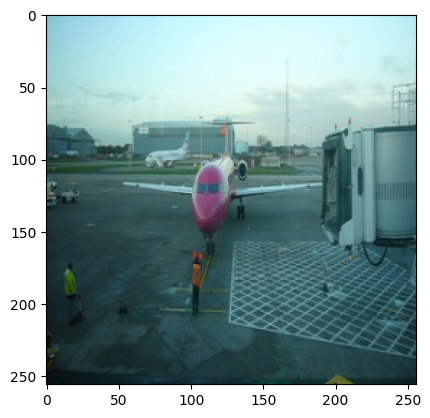

In [29]:
plt.imshow(image_rescaled.transpose(1, 2, 0))

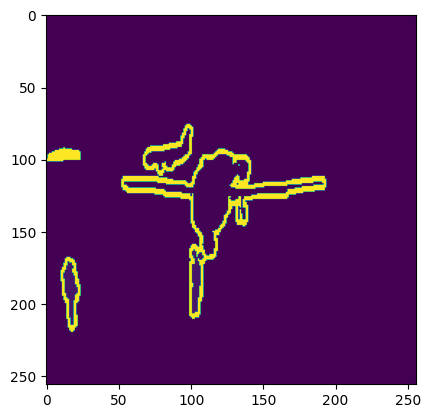

In [30]:
plt.imshow(mask.permute(1, 2, 0))

In [32]:
from skimage import color

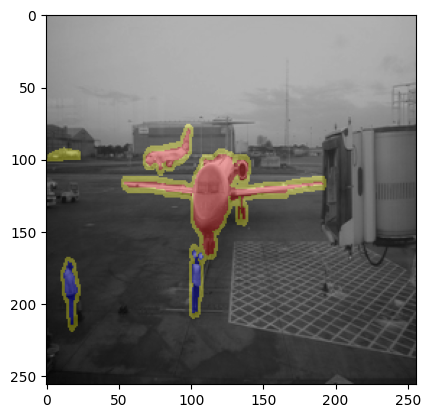

In [33]:
colored_mask = color.label2rgb(mask[0].numpy(), image_rescaled.transpose(1, 2, 0))
plt.imshow(colored_mask)

### U-Net Learning

For simplicity, make a binary classification model.
* person( id=15) vs background (id=0)

Pascal data is designed for 21 classes data.


In [47]:
class CustomVOCSegmentation(VOCSegmentation):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.person_class_id = 15
        self.data, self.targets = self.filter_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        mask = self.targets[index]
        return img, mask

    def filter_dataset(self):
        new_data = []
        new_targets = []
        for i in range(super().__len__()):
            img, mask = super().__getitem__(i)
            mask = (mask == self.person_class_id).long()
            if torch.sum(mask) > 0:
                new_data.append(img)
                new_targets.append(mask)
        return new_data, new_targets

# Data Augmetnation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, fill=(0,)), # 余白は背景とする (255をセットし，損失関数でignore_index=255にするのでもOK)
    mask_to_tensor,
    transforms.Lambda(lambda x: x.squeeze(0)) # DataLoaderから取得する時点で[b, 1, h, w]ではなく[b, h, w]にする (train loopで処理してもよい)
])

# validationではdata augmentaitonをしない
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    mask_to_tensor,
    transforms.Lambda(lambda x: x.squeeze(0))
])
trainset_person = CustomVOCSegmentation(root='./voc_data', year='2012', image_set='train', download=True, transform=train_transform, target_transform=train_target_transform)
valset_person = CustomVOCSegmentation(root='./voc_data', year='2012', image_set='val', download=True, transform=val_transform, target_transform=val_target_transform)
trainloader = DataLoader(trainset_person, batch_size=4, shuffle=True, num_workers=4)
valloader = DataLoader(valset_person, batch_size=4, num_workers=4)

Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data
Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### class weight

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# クラスの重みつけ計算
num_classes = 2
class_sample_counts = torch.zeros(num_classes, dtype=torch.int64)
for _, masks in trainloader:
    for mask in masks:
        mask = mask[mask != 255] # すでにDatasetのWrapperクラスで対処ずみだが，21クラス分類にする場合は必要
        class_sample_counts += torch.bincount(mask.flatten(), minlength=num_classes)
class_sample_counts = class_sample_counts.float() + 1e-5
# クラスの出現頻度の逆数を重みにする
class_weights = 1. / class_sample_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

In [49]:
model = UNet(in_ch=3, num_classes=num_classes)
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights) # すでにDatasetのWrapperクラスで対処ずみだが，21クラス分類にする場合はignoreする必要がある

### Training

In [50]:
num_epochs = 30
save_interval = 10  # every 10 epochs eval/save models

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(trainloader, total=len(trainloader), desc="Training", leave=False):
        images = images.to(device)
        masks = masks.to(device)
        # lossが(b, h, w)しか受け付けない -> transformでtransforms.Lambda(lambda x: x.squeeze(0))を実施していれば不要
        # masks = masks.squeeze(1)
        opt.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, masks)
        loss.backward()
        opt.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(trainloader):.4f}')

    # eval model per 10 epochs
    if (epoch + 1) % save_interval == 0:
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in valloader:
                images = images.to(device)
                masks = masks.to(device)
                # masks = masks.squeeze(1)

                outputs = model(images)
                loss = loss_func(outputs, masks)

                val_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(valloader):.4f}')

        # save a model
        torch.save(model.state_dict(), f'unet_epoch_{epoch+1}.pth')

Epoch [1/30], Training Loss: 0.6860


Epoch [2/30], Training Loss: 0.6740


Epoch [3/30], Training Loss: 0.6665


Epoch [4/30], Training Loss: 0.6665


Epoch [5/30], Training Loss: 0.6552


Epoch [6/30], Training Loss: 0.6505


Epoch [7/30], Training Loss: 0.6189


Epoch [8/30], Training Loss: 0.6053


Epoch [9/30], Training Loss: 0.5926


Epoch [10/30], Training Loss: 0.5793


Epoch [10/30], Validation Loss: 0.5328


Epoch [11/30], Training Loss: 0.5746


Epoch [12/30], Training Loss: 0.5627


Epoch [13/30], Training Loss: 0.5706


Epoch [14/30], Training Loss: 0.5513


Epoch [15/30], Training Loss: 0.5552


Epoch [16/30], Training Loss: 0.5457


Epoch [17/30], Training Loss: 0.5356


Epoch [18/30], Training Loss: 0.5279


Epoch [19/30], Training Loss: 0.5195


Epoch [20/30], Training Loss: 0.5119


Epoch [20/30], Validation Loss: 0.4800


Epoch [21/30], Training Loss: 0.5222


Epoch [22/30], Training Loss: 0.5110


Epoch [23/30], Training Loss: 0.5010


Epoch [24/30], Training Loss: 0.5102


Epoch [25/30], Training Loss: 0.4887


Epoch [26/30], Training Loss: 0.4859


Epoch [27/30], Training Loss: 0.4806


Epoch [28/30], Training Loss: 0.4721


Epoch [29/30], Training Loss: 0.4600


Epoch [30/30], Training Loss: 0.4540


Epoch [30/30], Validation Loss: 0.4988


In [ ]:
## load saved model
# import torch
# checkpoint = torch.load('unet_epoch_10.pth')
# model.load_state_dict(checkpoint)

### Visualize Model Prediction

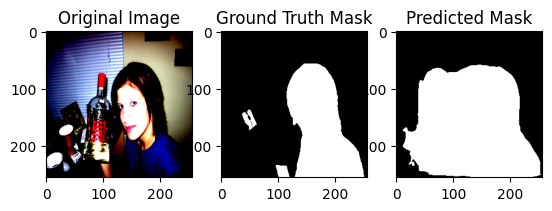

In [51]:
# visualize a model prediction
model.eval()
with torch.no_grad():
    images, masks = next(iter(valloader))
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    _, predicted_masks = torch.max(outputs, 1)

    # Move Tensor from GPU to CPU
    images = images.cpu()
    predicted_masks = predicted_masks.cpu()
    masks = masks.cpu()

    index = 2

    image = images[index].permute(1, 2, 0)
    predicted_mask = predicted_masks[index]
    mask = masks[index]

    # Tensor -> Numpy Array
    image = image.numpy()
    predicted_mask = predicted_mask.numpy()
    mask = mask.numpy()

    fig, ax = plt.subplots(1, 3)

    # Plot image
    ax[0].imshow(image)
    ax[0].title.set_text('Original Image')

     # Plot mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].title.set_text('Ground Truth Mask')

    # Plot prediction
    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].title.set_text('Predicted Mask')

    plt.show()

### Raw model output

for multi-class, apply softmax first

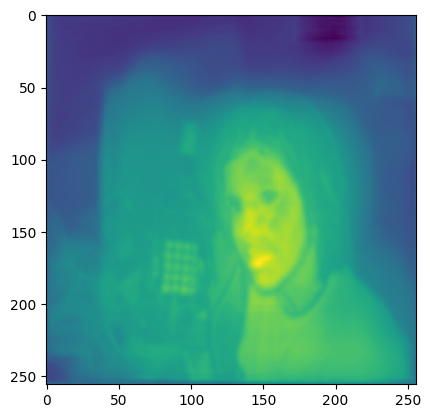

In [52]:
pred_map = outputs[index, 1, :, :]
plt.imshow(pred_map.cpu())

For improvement,
 * Add BatchNorm layer
 * Kaiming initialization